In [1]:
import torch

dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")

net = torch.hub.load('pytorch/vision:v0.9.0', 'vgg11', pretrained=True)
net = net.eval().to(dev)
 
# we are not changing the network weights/biases in this lab
for param in net.parameters():
    param.requires_grad = False
print(net)

Using cache found in /home/whiplash/.cache/torch/hub/pytorch_vision_v0.9.0


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

# Assignment 1

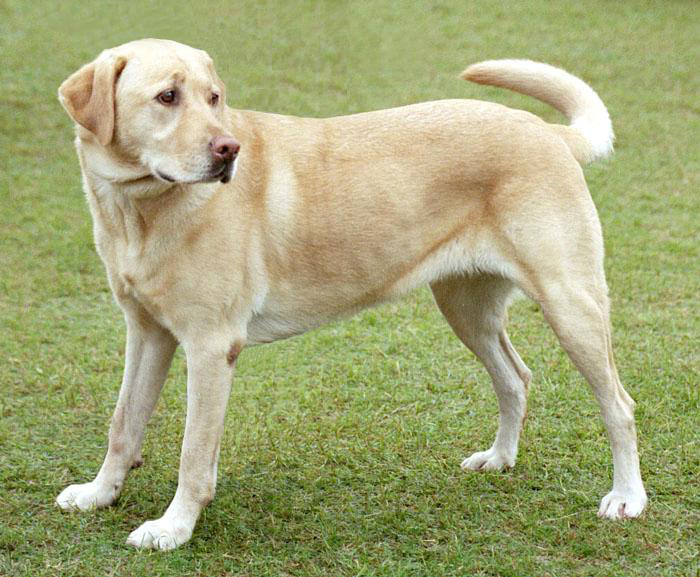

In [2]:
from PIL import Image

image = Image.open("dog.jpg")
image

In [3]:
from torchvision import transforms

transform = transforms.Compose([  
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

x = torch.unsqueeze(transform(image), 0)
x.shape

torch.Size([1, 3, 224, 271])

In [4]:
from matplotlib import pyplot as plt

def visualize(x):
    x_new = x.cpu().numpy().transpose(1, 2, 0)
    plt.imshow(x_new)

In [5]:
torch.min(x)

tensor(-1.8606)

The final tensor isn't within the plotting bounds ([0..1]), so some values are clipped. Should I linearly map it to the range [0..1]? I don't know, so I'll leave as it is

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


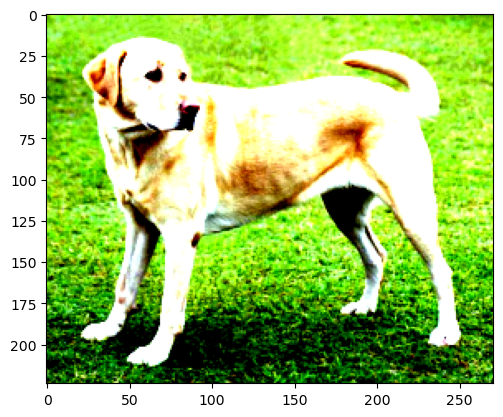

In [6]:
from torchvision.utils import make_grid

visualize(make_grid(x))

In [7]:
out = torch.squeeze(net(x))
scores, indices = out.sort(descending=True)

with open("imagenet_classes.txt", "r") as f:
    classes = [s.strip() for s in f.readlines()]

print(f"Top 10 classes:")
for i in indices[:10]:
    print(f"{classes[i]}: {out[i]:.4f}")

Top 10 classes:
Labrador retriever: 13.2488
golden retriever: 11.4361
Chesapeake Bay retriever: 11.3244
bloodhound, sleuthhound: 8.7572
Weimaraner: 8.5056
kelpie: 8.4786
kuvasz: 8.3887
tennis ball: 8.3270
Rhodesian ridgeback: 8.1778
redbone: 8.0941


# Assignment 2

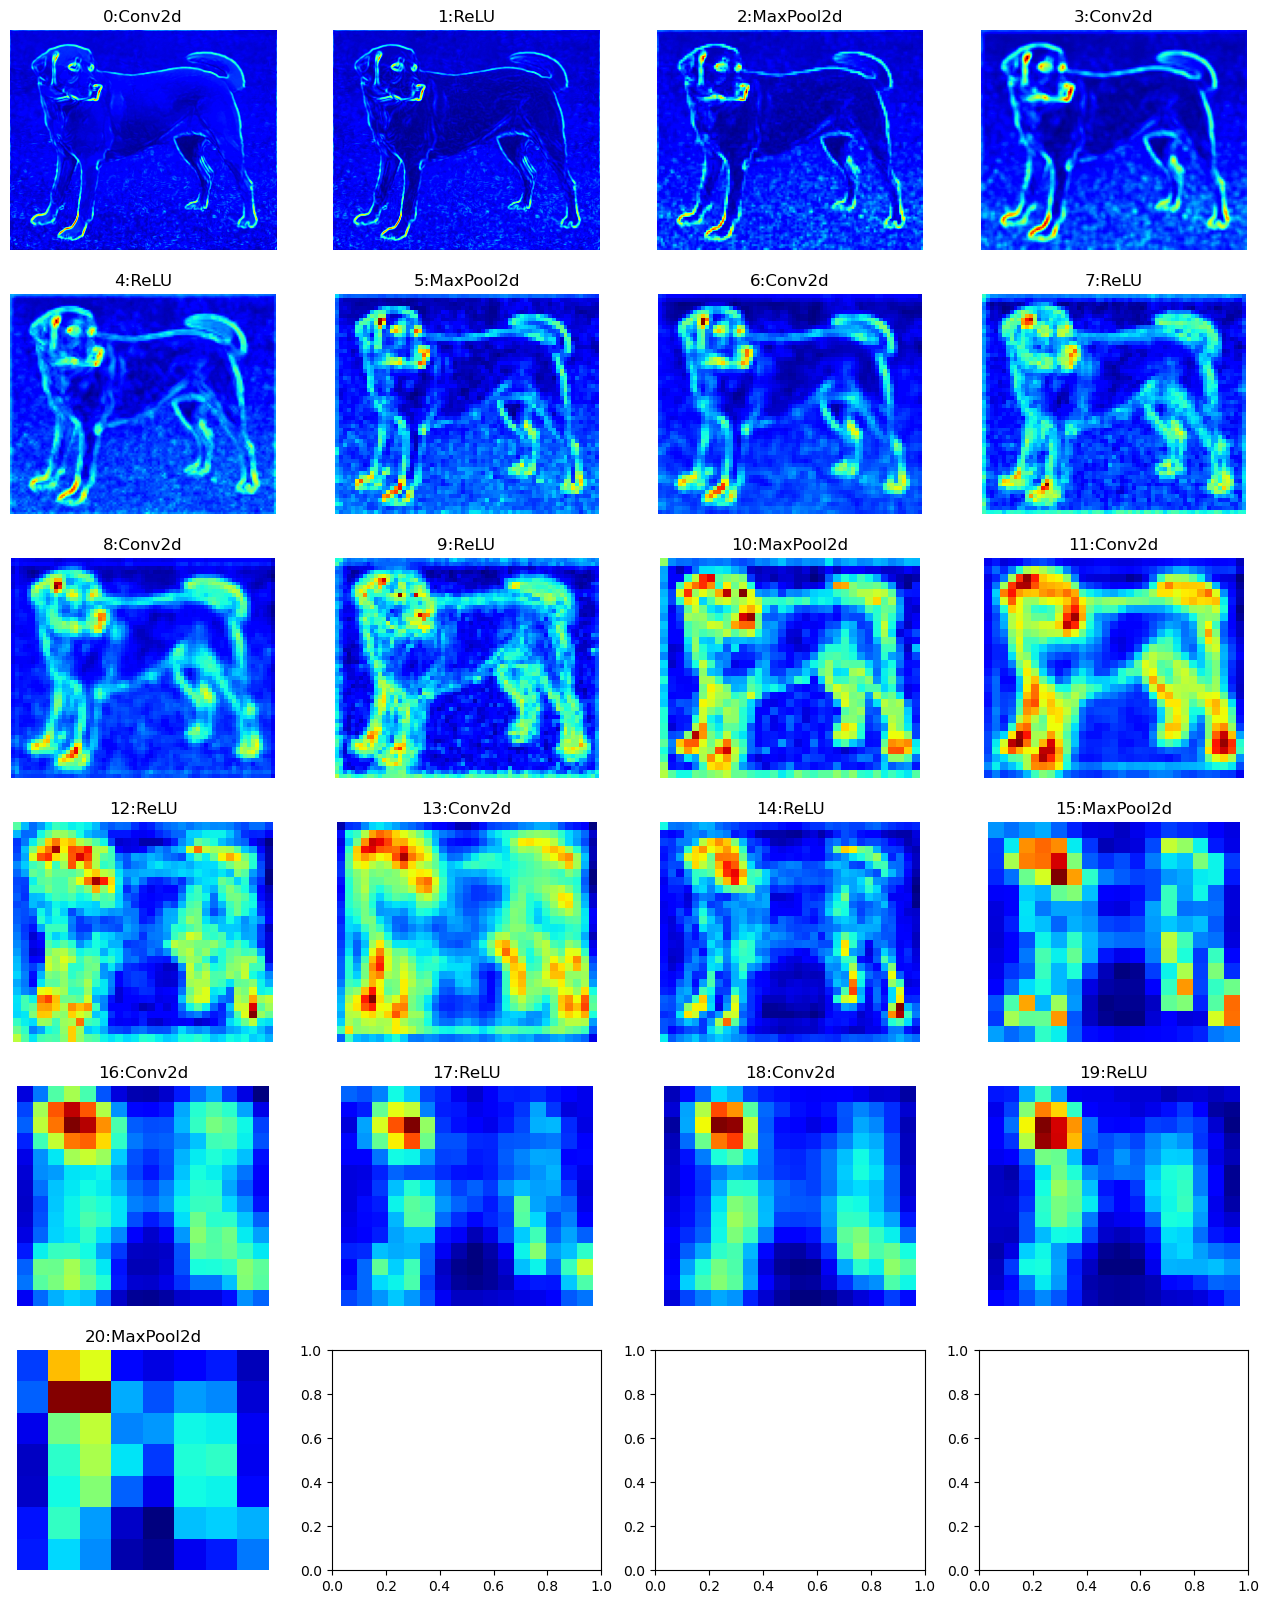

In [8]:
fig, axs = plt.subplots(nrows=6, ncols=4, figsize=(16, 20))
fm = x
fm.requires_grad = True
feature_maps = []

for i, l in enumerate(net.features):
    fm.retain_grad()
    fm = l.forward(fm)
    feature_maps.append(fm)
    
    f = (fm.detach() ** 2).sum(dim=1).sqrt()[0]
    axs.flat[i].imshow(f.cpu().numpy(), cmap='jet')
    axs.flat[i].set_axis_off()
    axs.flat[i].set_title("{}:{}".format(i, l.__class__.__name__))
    
# computing the rest and the backpropagation
after_pooling = torch.flatten(net.avgpool(fm))
out = net.classifier(after_pooling)
out.max().backward()

The last feature map always has None gradient. I couldn't have debugged that :(

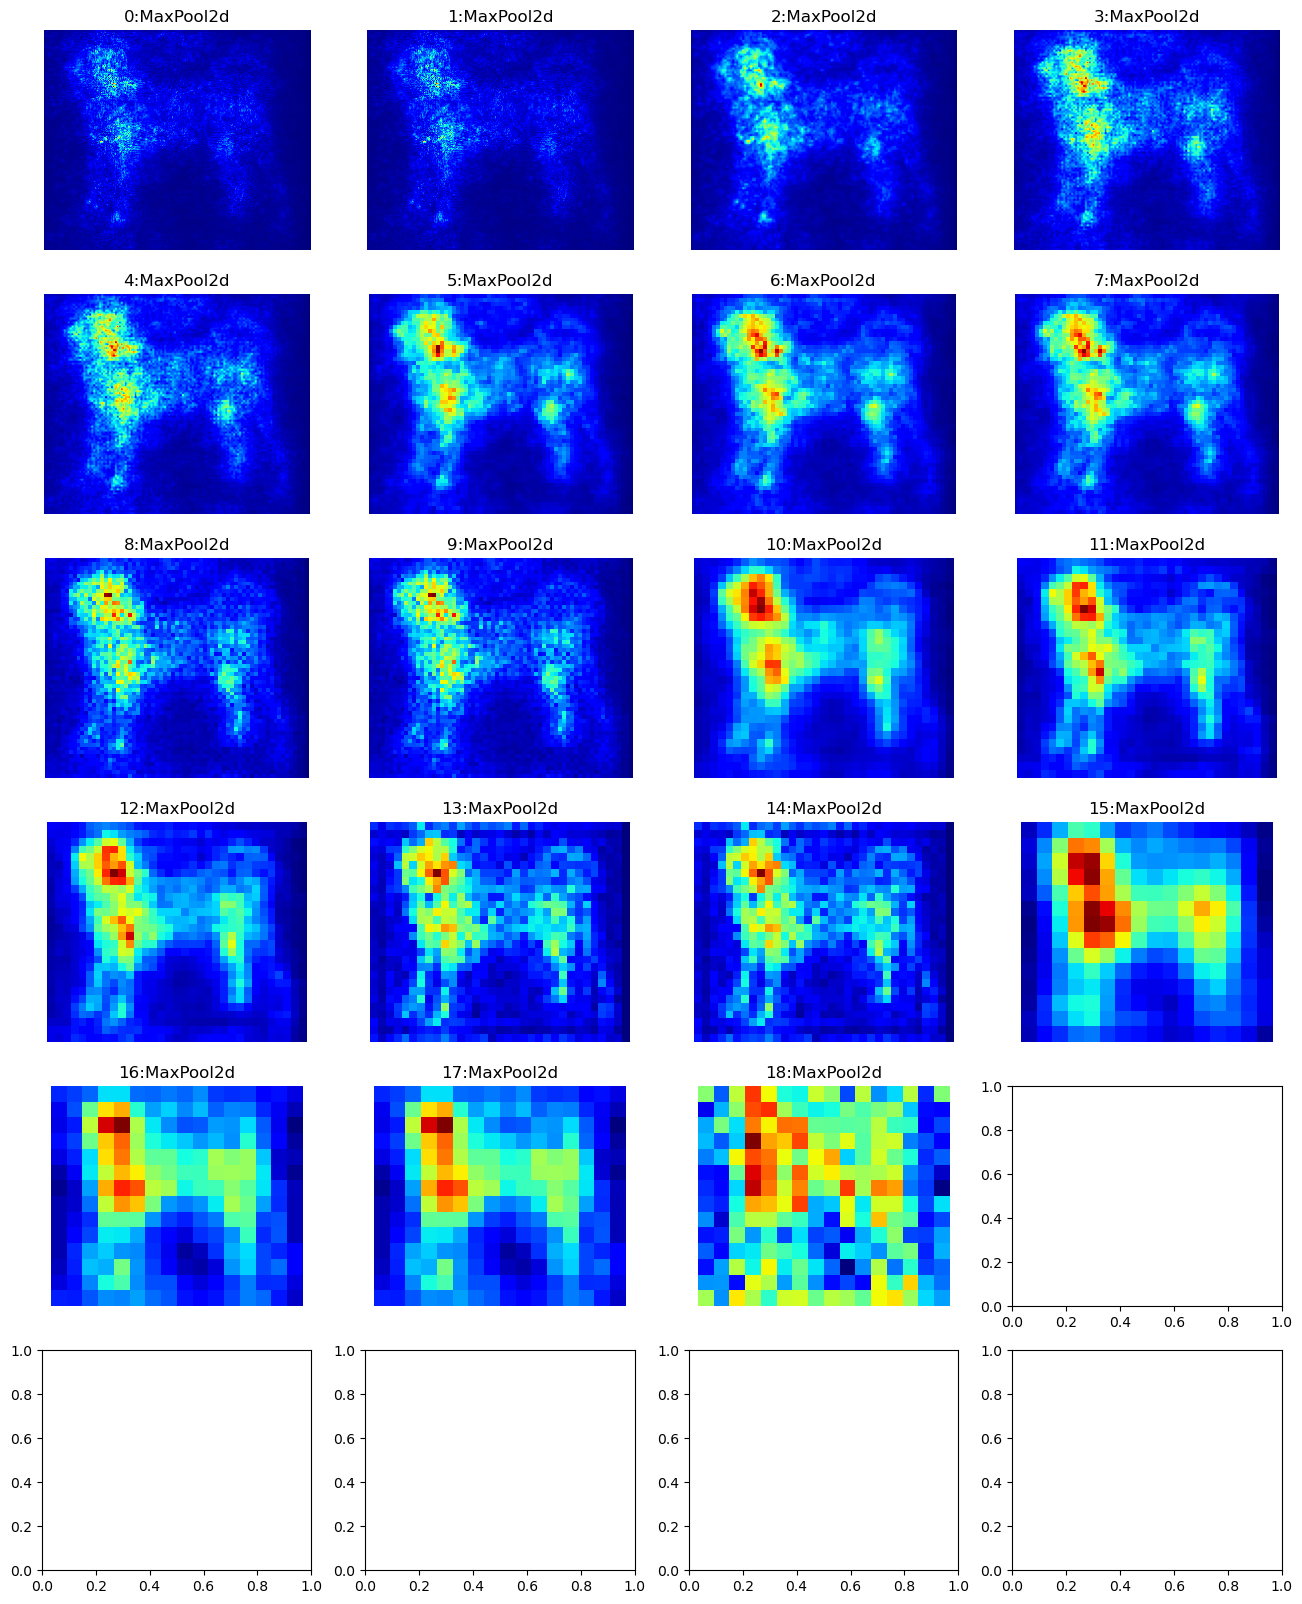

In [9]:
fig, axs = plt.subplots(nrows=6, ncols=4, figsize=(16, 20))

for i in range(19):
    f = (feature_maps[i].grad.detach() ** 2).sum(dim=1).sqrt()[0]
    axs.flat[i].imshow(f.cpu().numpy(), cmap='jet')
    axs.flat[i].set_axis_off()
    axs.flat[i].set_title("{}:{}".format(i, l.__class__.__name__))

# Assignment 3

In [10]:
from torch import nn

def receptive_field(net, layer_idx):
    rc = None
    jump = None
    
    for i, p in enumerate(net.features):
        if isinstance(p, nn.Conv2d) or isinstance(p, nn.MaxPool2d):
            size = p.kernel_size[0] if isinstance(p, nn.Conv2d) else p.kernel_size
            stride = p.stride[0] if isinstance(p, nn.Conv2d) else p.stride
            
            if rc is None:
                rc = size
                jump = stride
            else:
                rc = rc + (size - 1) * jump
                jump *= stride

        if i == layer_idx:
            return rc
    
    raise Exception("Not allowed state")

receptive_field(net, 20)

150

In [43]:
import math

def partial_forward(net, up_to_layer, x):
    a = x
    for i, l in enumerate(net.features):
        a = l(a)
        if i == up_to_layer:
            return a
    
    raise Exception("Invalid state")

def plot_tensor(x):
    image = x.cpu().detach().numpy().transpose(1, 2, 0)
    plt.imshow(image, cmap='jet')
    plt.axis('off')

def plot_grid(x, per_row=1, figsize=(16, 20)):
    rows = math.ceil(x.shape[0] / per_row)
    fig, axs = plt.subplots(nrows=rows, ncols=per_row, figsize=figsize)

    for i in range(rows * per_row):
        axs.flat[i].set_axis_off()
        
        if i >= x.shape[0]:
            continue
        
        image = x[i].cpu().detach().numpy().transpose(1, 2, 0)
        axs.flat[i].imshow(image, cmap='jet')
#         axs.flat[i].set_title("{}:{}".format(i, l.__class__.__name__))

Because pyplot only takes the images with values 0..1 or 0..255, we need a function to remap the tensors

In [12]:
def linear_map(x, a=0, b=1):
    y = x.clone()
    y -= torch.amin(y, keepdim=True)
    y /= torch.amax(y, keepdim=True)
    return y

I couldn't have implemented smoothing, I've always been getting `RuntimeError: Padding length too large` :(

The next cell presents the patterns with maximum activation for the first layer. I did a linear mapping to the 0..1 interval, because otherwise the values are too small to see anything

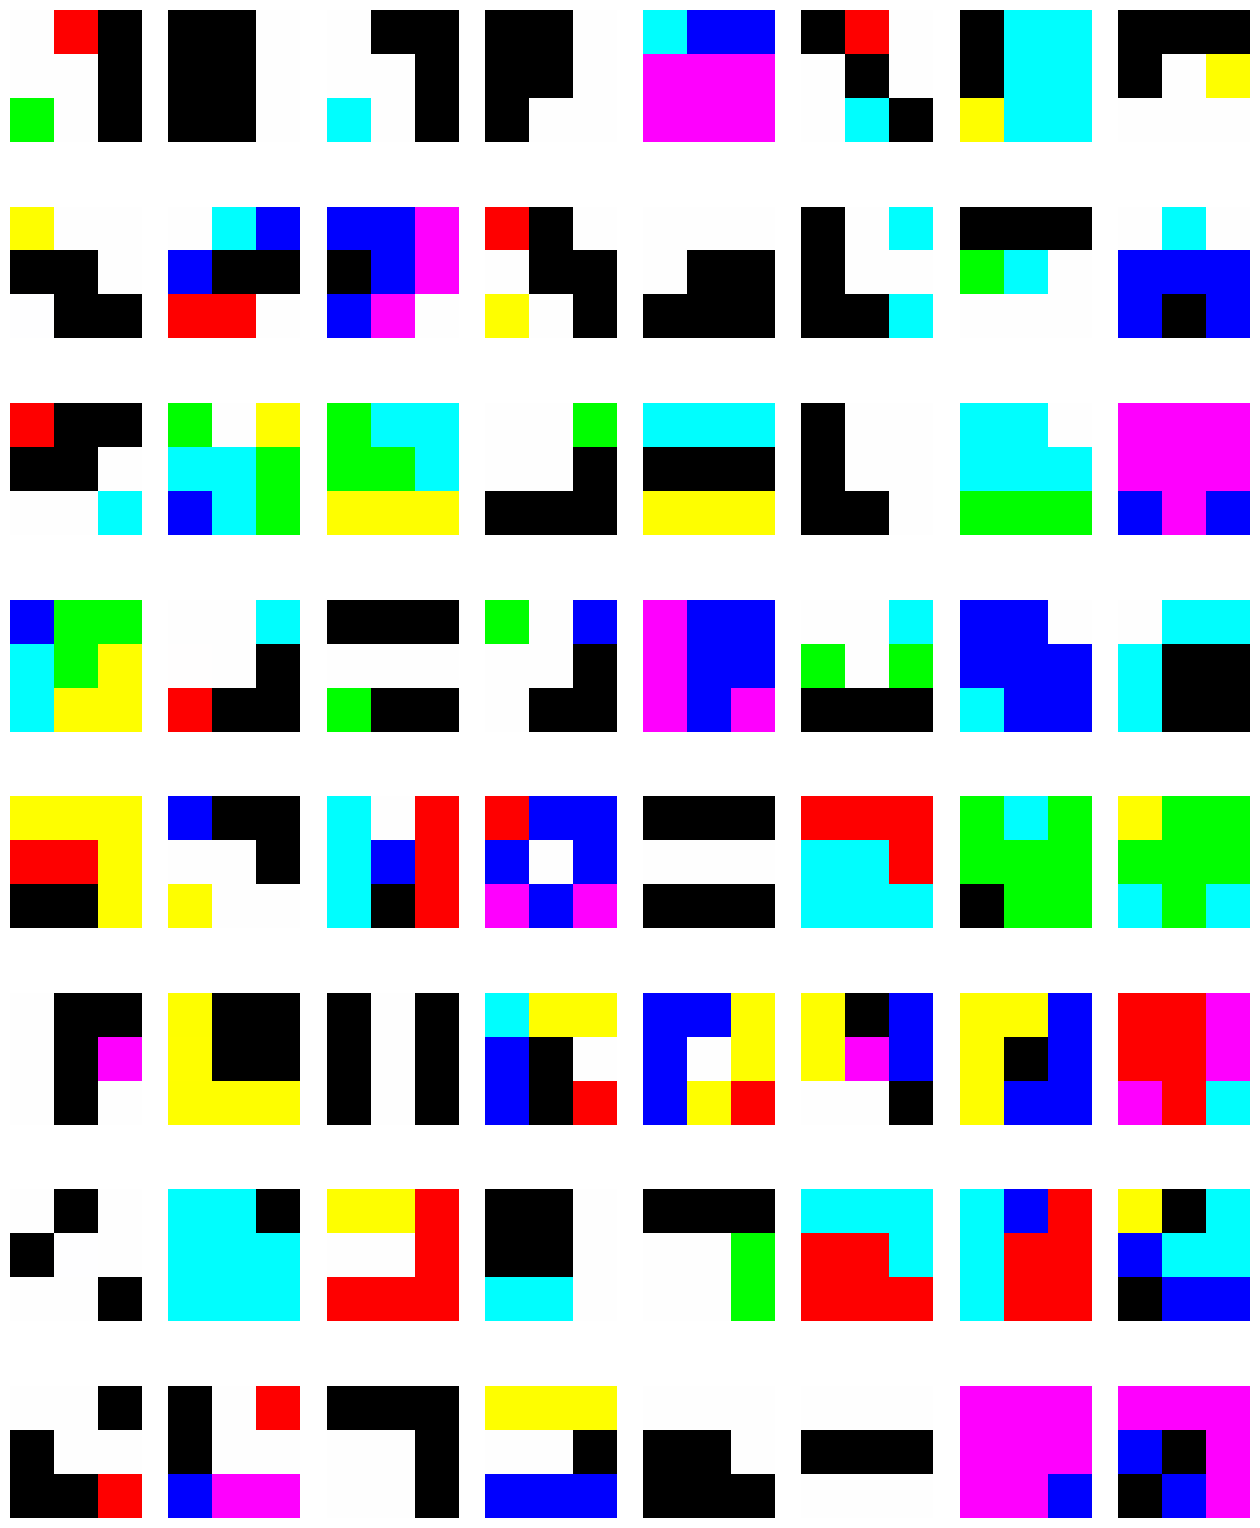

In [21]:
apool = torch.nn.AvgPool2d(3, padding=0, stride=1)
apad = torch.nn.ReplicationPad2d(1)

def activation_max(net, layer_idx, lr=1e-3, iterations=1, eps=1e-1):
    rc = receptive_field(net, layer_idx)
    channels = list(net.features)[layer_idx].out_channels
    x = torch.nn.Parameter(torch.zeros(channels, 3, rc, rc)).to(dev)
    optimizer = torch.optim.Adam([x], lr=lr, maximize=True)
    
    for i in range(iterations):
        optimizer.zero_grad()
        a = partial_forward(net, layer_idx, x)
        out = a[:, :, a.shape[2] // 2, a.shape[3] // 2].diag().sum()
        out.backward()
        optimizer.step()
        
        with torch.no_grad():
            # clipping
            out = torch.clip(out, -1, 1)
            
            # there's some error with smoothing which I couldn't have debugged :\
            
            # smoothing
#             xx = apool(apad(out))
#             diff = out - xx
#             dn = torch.linalg.norm(diff.flatten(2), dim=2, ord=1.0) / (rc * rc)
#             if dn.max() > eps:
#                 out.data[dn > eps] = xx[dn > eps]
        
    return x

plot_grid(linear_map(activation_max(net, 0, iterations=100)), 8)

The 3-rd layer (2-nd convolution) results

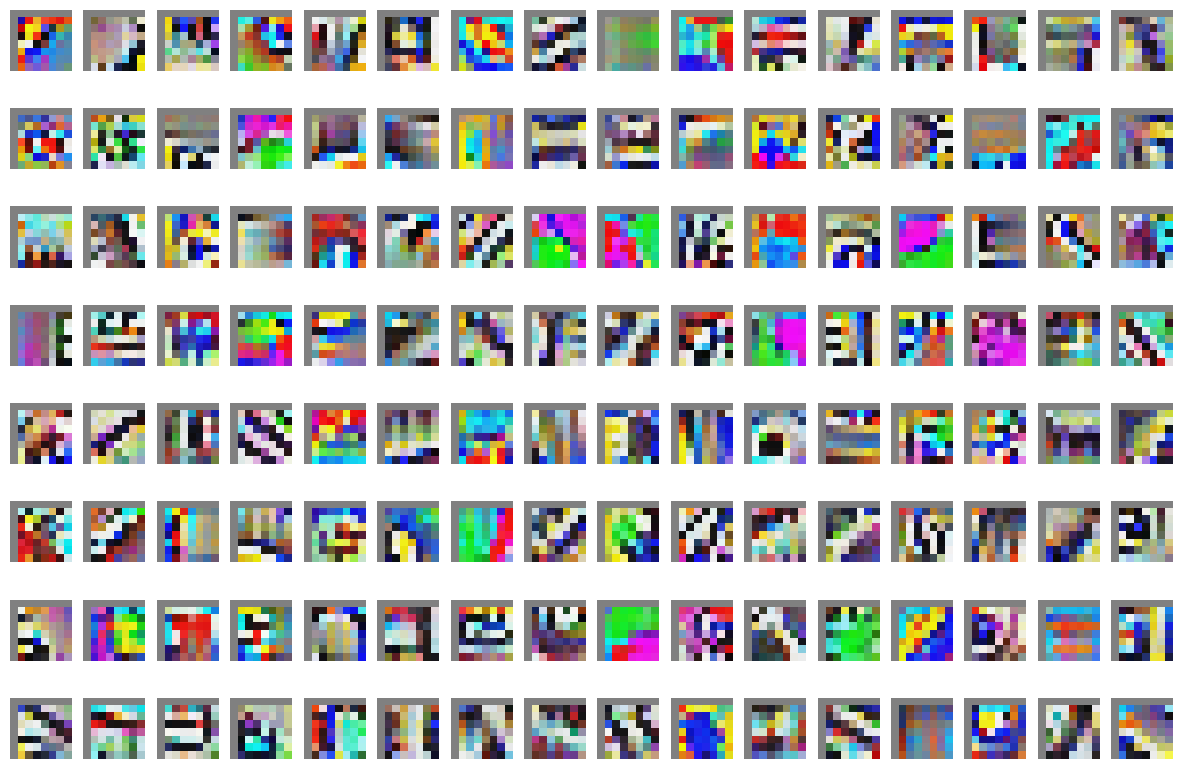

In [22]:
activation_map = activation_max(net, 3, lr=0.01, iterations=50)
mapped = linear_map(activation_map)
plot_grid(mapped, per_row=16, figsize=(15, 10))

The last convolution

In [24]:
activation_map = activation_max(net, 18, lr=1e-2, iterations=1)
mapped = linear_map(activation_map)

It's hard to visualize all the 512 receptive fields (they are big), so I'll better visualize a few in separate cells

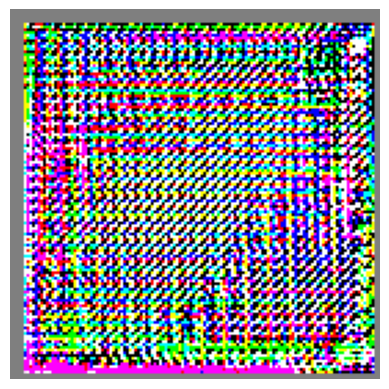

In [45]:
plot_tensor(mapped[0])

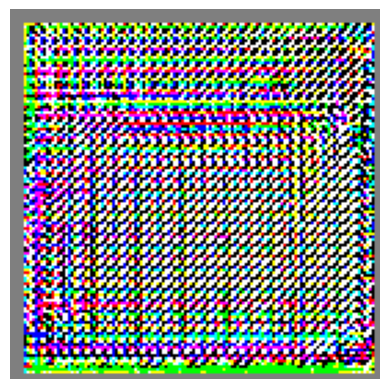

In [46]:
plot_tensor(mapped[128])

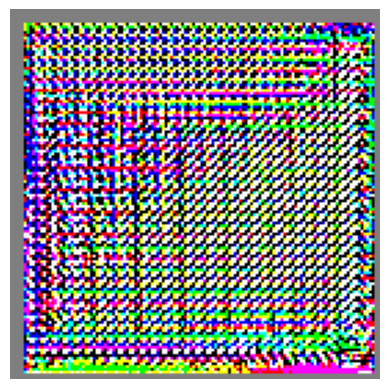

In [47]:
plot_tensor(mapped[234])

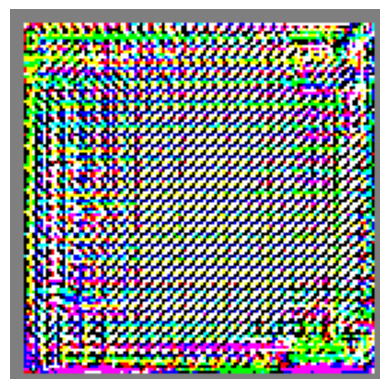

In [48]:
plot_tensor(mapped[511])

# Assignment 4

I don't know why but x was not a leaf variable, so I couldn't have do any backpropgation. So a created a new but the same tensor

In [71]:
transform = transforms.Compose([  
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

y = torch.unsqueeze(transform(image), 0)
y.shape

torch.Size([1, 3, 224, 271])

Just a side question, why can't we maximize the net output directly instead of an extra softmax layer?

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Top 5 classes:
wall clock: 20.4277
analog clock: 13.8009
barometer: 10.6800
bolo tie, bolo, bola tie, bola: 9.9257
switch, electric switch, electrical switch: 9.6557


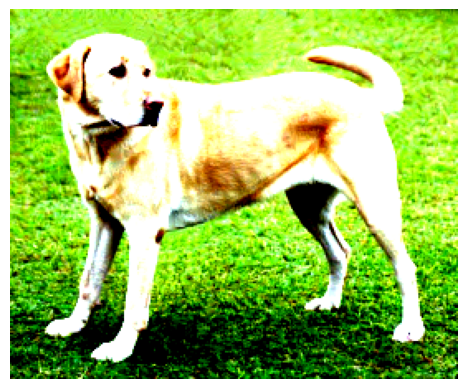

In [92]:
def adversarial_attack(net, x, target_idx=892, iters=100):
    x0 = x.clone()
    x = x.requires_grad_() 
    optim = torch.optim.Adam([x], lr=1e-3, maximize=True)
    
    for _ in range(iters):
        optim.zero_grad()
        scores = net(x)
        target_prob = nn.functional.softmax(scores, dim=-1)[:, target_idx]
        target_prob.backward()
        optim.step()
        
#         with torch.no_grad():
#             dx = x.detach() - x0
#             dn = dx.flatten().norm(p=float('inf'))
#             div = torch.clamp(dn/eps, min=1.0)
#             dx = dx / div
#             x.data = x0 + dx
        
    return x

def print_top_classes(net, x, top_n=5):
    out = torch.squeeze(net(x))
    scores, indices = out.sort(descending=True)

    print(f"Top {top_n} classes:")
    for i in indices[:top_n]:
        print(f"{classes[i]}: {out[i]:.4f}")

adversarial_example = adversarial_attack(net, y.clone())
plot_tensor(adversarial_example[0])
print_top_classes(net, adversarial_example)

I know that the right implementation must have updates through a sign of the gradient, but I don't have enough time to implement it through the Adam optimizer (sorry) (and is it even needed? the direct gradient updates work fine)

The clean image for comparison

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Top 5 classes:
Labrador retriever: 13.2488
golden retriever: 11.4361
Chesapeake Bay retriever: 11.3244
bloodhound, sleuthhound: 8.7572
Weimaraner: 8.5056


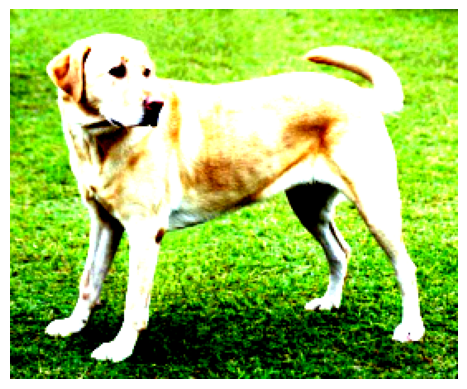

In [84]:
plot_tensor(x[0])
print_top_classes(net, x)

So as we can see, the adversarial attack has succeeded, I can't see any difference, but the network recognizes the image as a clock